In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('BuildingPermits.csv')
df.head()

# Data Cleaning

In [ ]:
column_headers = df.columns.tolist()
date_columns = []
for header in column_headers:
    if "Date" in header:
        date_columns.append(header)
        df[header] = pd.to_datetime(df[header], errors='coerce')
        print(header)

In [ ]:
df['Day of Week'] = df['Filed Date'].dt.dayofweek
df['Month'] = df['Filed Date'].dt.month

In [ ]:
str_cols = ['Street Number Suffix', 'Unit Suffix', 'Structural Notification', 'Fire Only Permit', 'Existing Use', 'Proposed Use', 'Existing Construction Type Description', 'Proposed Construction Type Description', 'Site Permit']
for col in str_cols:
    df[col].fillna('', inplace=True)

# fills in number and datetime blanks with 0
df.fillna(0, inplace=True)

In [ ]:
categorical_cols = [
    'Permit Type',
    'Current Status',
    'Existing Use',
    'Proposed Use',
    'Existing Construction Type',
    'Proposed Construction Type',
    'Supervisor District',
    'Neighborhoods - Analysis Boundaries',
    'Zipcode',
    'Day of Week',
    'Plansets',
    'Month'
]

numeric_cols = [
    'Number of Existing Stories',
    'Number of Proposed Stories',
    'Estimated Cost',
    'Unit',
    'Revised Cost',
    'Existing Units',
    'Proposed Units'
]

datetime_cols = [
    'Issued Date',
    'Completed Date',
    'First Construction Document Date',
    'Permit Expiration Date'
]

# Location - split into lat and long, regress on lat and long
# Voluntary Soft-Story Retrofit - ??, no values (skip it)
# TIDF Compliance

In [ ]:
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [ ]:
# convert datetime to floats
# for col in datetime_cols:
#     df[col] = (df[col] - df[col].min()) / np.timedelta64(1, 'D')

df = df[
    (df['Permit Expiration Date'] != 0)
]
df.reset_index(drop=True, inplace=True)
print(f"Rows after dropping empty expiration dates: {len(df)}")

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    min_date = df[col].min()
    print(f"Min date for {col}: {min_date}")
    df[col] = (df[col] - min_date).dt.total_seconds() / (24 * 60 * 60)
    df[col] = df[col].fillna(0)


In [ ]:
df = df[~df['Revised Cost'].isin([0, 1])]
df.reset_index(drop=True, inplace=True)
print(f"rows left:{len(df)}")


In [ ]:
df.to_csv('change.csv')

# 3. Regression

## Predicting Cost

### XGBoost
XGBoost is the intuitive choice for this problem since we're doing regression on categorical and numeric data.

In [ ]:
features = np.concatenate((categorical_cols, numeric_cols, datetime_cols))
X = df[features].drop(['Estimated Cost', 'Revised Cost'], axis=1)
eps = 1 # avoid 0
y = np.log1p(df['Revised Cost'] + eps)
X.dtypes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(type(X_train))
print(type(y_train))

In [ ]:
model = xgb.XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='rmse',
)

In [ ]:
print(len(X_test))
len(X_train)

In [266]:
def random_search(model, param_distributions, X, y, n_iter=100, cv=3):
    search = RandomizedSearchCV(
        model, param_distributions, n_iter=n_iter, cv=cv, 
        verbose=2, n_jobs=-1, random_state=42
    )
    search.fit(X, y)
    return search.best_params_, search.best_score_

model = xgb.XGBRegressor(tree_method='hist', enable_categorical=True)

param_dist1 = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6)
}
best_params1, _ = random_search(model, param_dist1, X_train, y_train)
model.set_params(**best_params1)

param_dist2 = {
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}
best_params2, _ = random_search(model, param_dist2, X_train, y_train)
model.set_params(**best_params2)

param_dist3 = {
    'learning_rate': uniform(0.01, 0.29),
    'n_estimators': randint(100, 1000)
}
best_params3, best_score = random_search(model, param_dist3, X_train, y_train)
model.set_params(**best_params3)

best_params = {**best_params1, **best_params2, **best_params3}

print("Best parameters:", best_params)
print("Best score:", best_score)

final_model = xgb.XGBRegressor(**best_params, tree_method='hist', enable_categorical=True, use_label_encoder=False)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ....................max_depth=7, min_child_weight=3; total time=   1.6s
[CV] END ....................max_depth=7, min_child_weight=3; total time=   1.6s
[CV] END ....................max_depth=7, min_child_weight=5; total time=   1.7s
[CV] END ....................max_depth=7, min_child_weight=5; total time=   1.8s
[CV] END ....................max_depth=7, min_child_weight=3; total time=   1.8s
[CV] END ....................max_depth=9, min_child_weight=4; total time=   2.8s
[CV] END ....................max_depth=9, min_child_weight=4; total time=   2.8s
[CV] END ....................max_depth=9, min_child_weight=4; total time=   2.8s
[CV] END ....................max_depth=5, min_child_weight=3; total time=   0.9s
[CV] END ....................max_depth=7, min_child_weight=5; total time=   1.4s
[CV] END ....................max_depth=5, min_child_weight=3; total time=   0.8s
[CV] END ....................max_depth=5, min_

In [268]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6298202574719083), device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.0807964014518545), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=926, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [269]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Metrics:")
print(f"Mean Squared Error: {mse}") 
print(f"R-squared Score: {r2}") 

y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Metrics:")
print(f"Mean Squared Error: {train_mse}")
print(f"R-squared Score: {train_r2}")


Test Metrics:
Mean Squared Error: 1.0736422448891956
R-squared Score: 0.6233549886823708

Training Metrics:
Mean Squared Error: 0.7499665141117254
R-squared Score: 0.7403963776798104


Precision within 25% tolerance: 0.9436
Precision within 20% tolerance: 0.9141
Precision within 15% tolerance: 0.8487
Precision within 10% tolerance: 0.7003
Precision within 5% tolerance: 0.4179


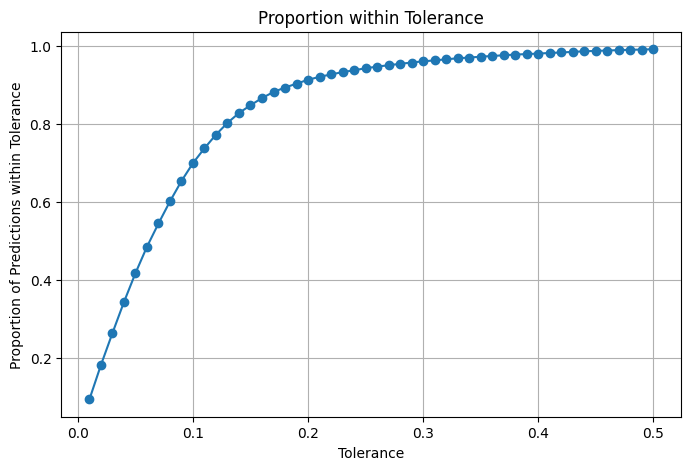

In [271]:
def regression_precision(y_true, y_pred, tolerance=0.1):
    good = np.abs(y_true-y_pred) <= (tolerance*y_true)
    return np.mean(good)

precision_25 = regression_precision(y_test, y_pred, tolerance=0.25)
print(f"Precision within 25% tolerance: {precision_25:.4f}")

precision_20 = regression_precision(y_test, y_pred, tolerance=0.2)
print(f"Precision within 20% tolerance: {precision_20:.4f}")

precision_15 = regression_precision(y_test, y_pred, tolerance=0.15)
print(f"Precision within 15% tolerance: {precision_15:.4f}")

precision_10 = regression_precision(y_test, y_pred)
print(f"Precision within 10% tolerance: {precision_10:.4f}")

precision_5 = regression_precision(y_test, y_pred, tolerance=0.05)
print(f"Precision within 5% tolerance: {precision_5:.4f}")

tolerances = np.arange(0.01, 0.51, 0.01)
precisions = [regression_precision(y_test, y_pred, tolerance=t) for t in tolerances]

plt.figure(figsize=(8, 5))
plt.plot(tolerances, precisions, marker='o')
plt.title('Proportion within Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Proportion of Predictions within Tolerance')
plt.grid(True)

plt.show()

### Feature Importance

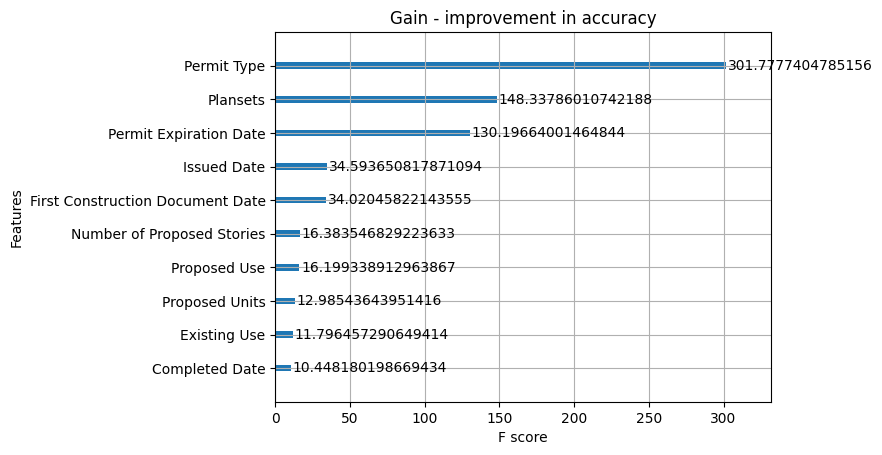

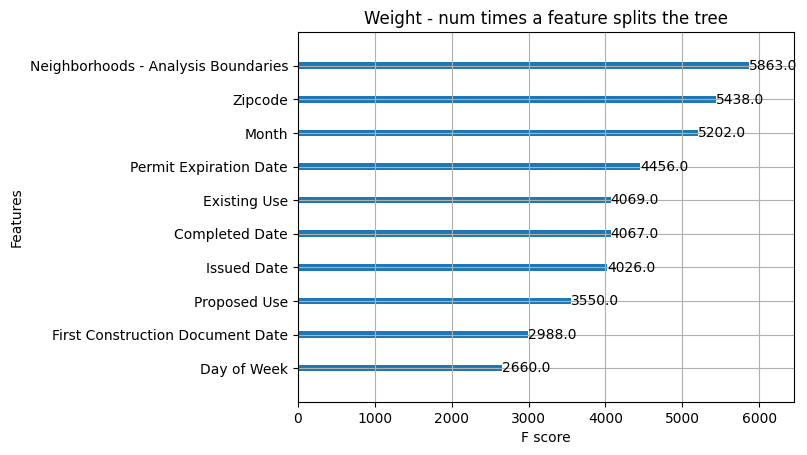

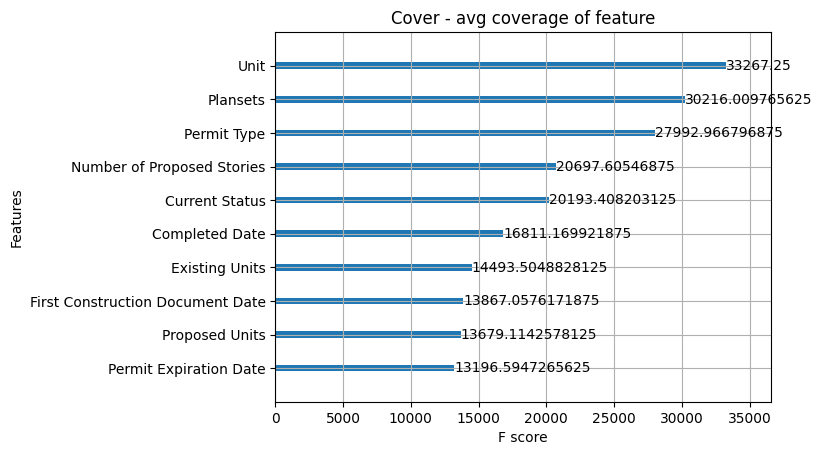

In [272]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('Gain - improvement in accuracy')
plt.show()

xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Weight - num times a feature splits the tree')
plt.show()

xgb.plot_importance(model, importance_type='cover', max_num_features=10)
plt.title('Cover - avg coverage of feature')
plt.show()

### Linear Regression, Selected Features

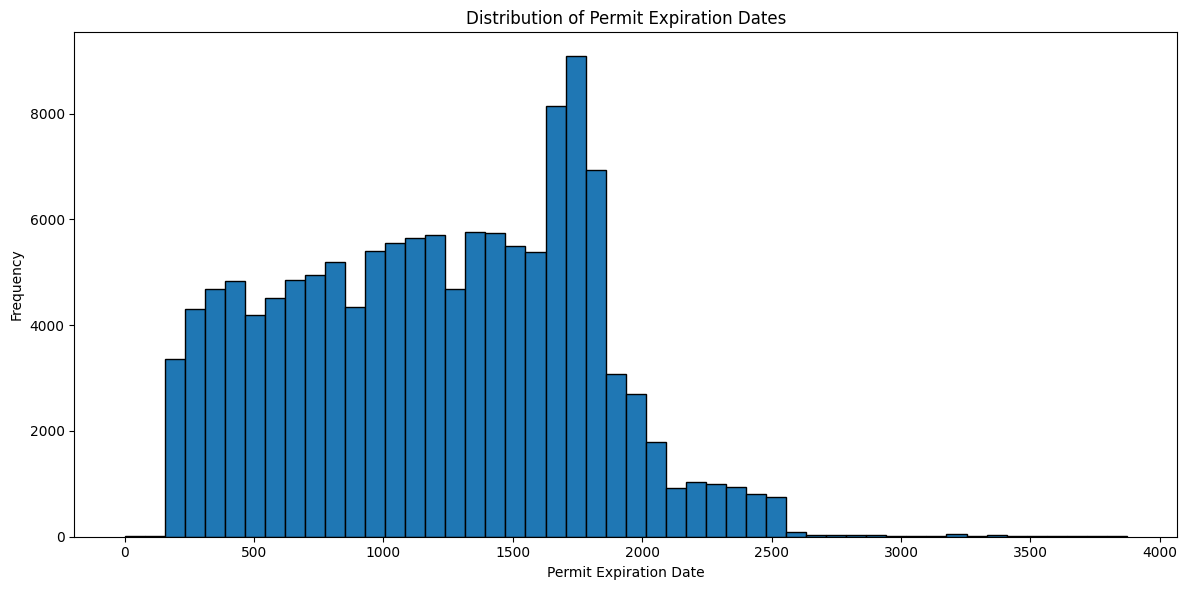

Summary statistics of Permit Expiration Date:
count    132191.000000
mean       1202.473315
std         569.618127
min           0.000000
25%         733.000000
50%        1217.000000
75%        1677.000000
max        3873.000000
Name: Permit Expiration Date, dtype: float64


In [273]:
plt.figure(figsize=(12, 6))
plt.hist(df['Permit Expiration Date'], bins=50, edgecolor='black')
plt.xlabel('Permit Expiration Date')
plt.ylabel('Frequency')
plt.title('Distribution of Permit Expiration Dates')
plt.xticks()
plt.tight_layout()
plt.show()

# Calculate summary statistics
expiration_stats = df['Permit Expiration Date'].describe()
print("Summary statistics of Permit Expiration Date:")
print(expiration_stats)




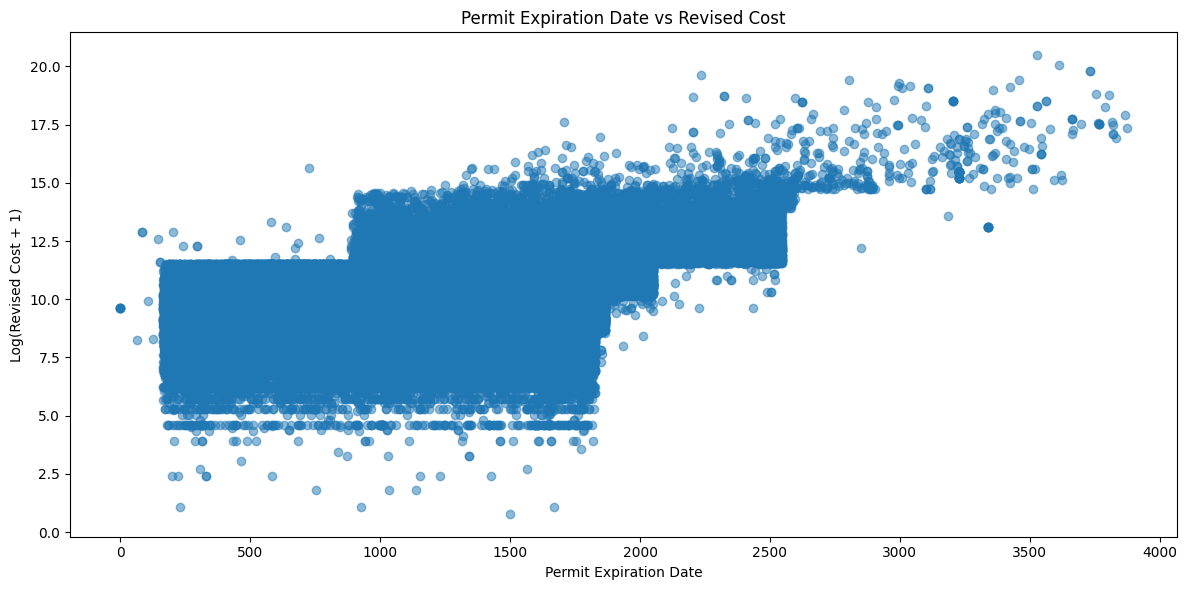

Correlation between Permit Expiration Date and Log(Revised Cost + eps): 0.3853


In [274]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Permit Expiration Date'], np.log1p(df['Revised Cost']), alpha=0.5)
plt.xlabel('Permit Expiration Date')
plt.ylabel('Log(Revised Cost + 1)')
plt.title('Permit Expiration Date vs Revised Cost')
plt.xticks()
plt.tight_layout()
plt.show()

correlation = df['Permit Expiration Date'].corr(np.log1p(df['Revised Cost']))
print(f"Correlation between Permit Expiration Date and Log(Revised Cost + eps): {correlation:.4f}")


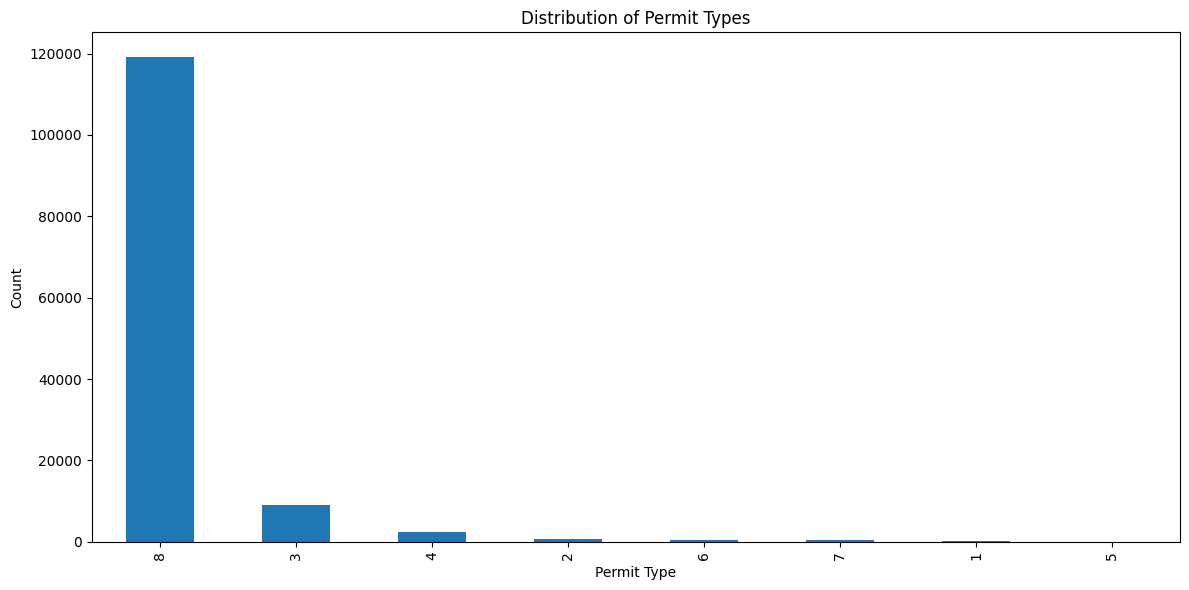

Permit Type
8    119254
3      8966
4      2392
2       601
6       375
7       354
1       176
5        73
Name: count, dtype: int64


In [275]:
plt.figure(figsize=(12, 6))
permit_type_counts = df['Permit Type'].value_counts()
permit_type_counts.plot(kind='bar')
plt.title('Distribution of Permit Types')
plt.xlabel('Permit Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(permit_type_counts.head(10))


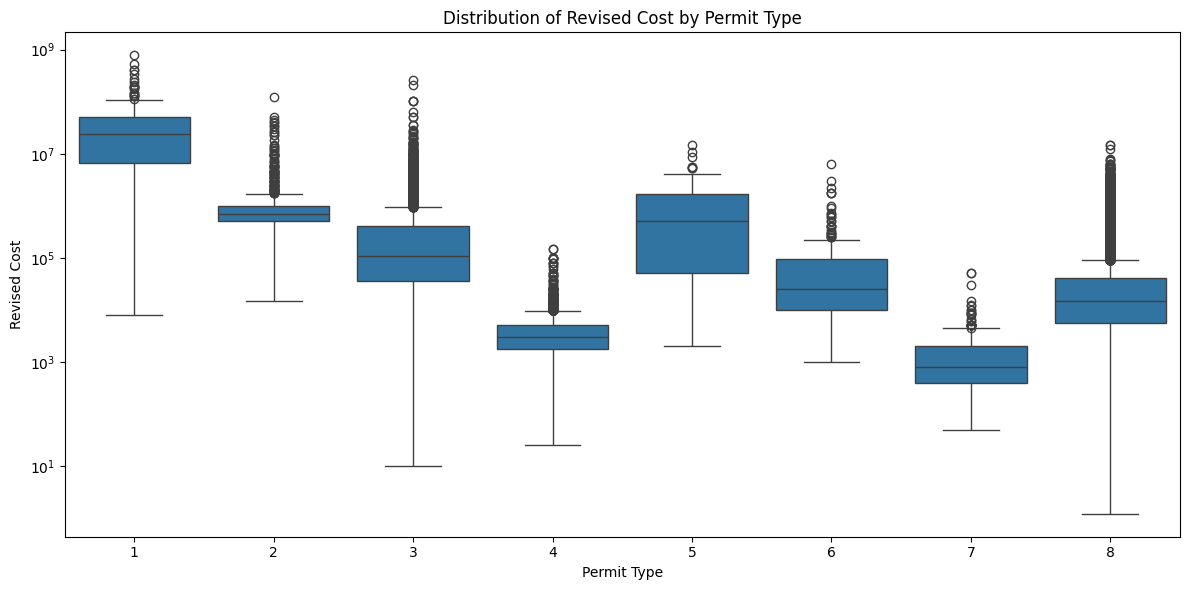

In [276]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Permit Type', y='Revised Cost', data=df)
plt.title('Distribution of Revised Cost by Permit Type')
plt.xlabel('Permit Type')
plt.ylabel('Revised Cost')
plt.yscale('log')
plt.tight_layout()
plt.show()


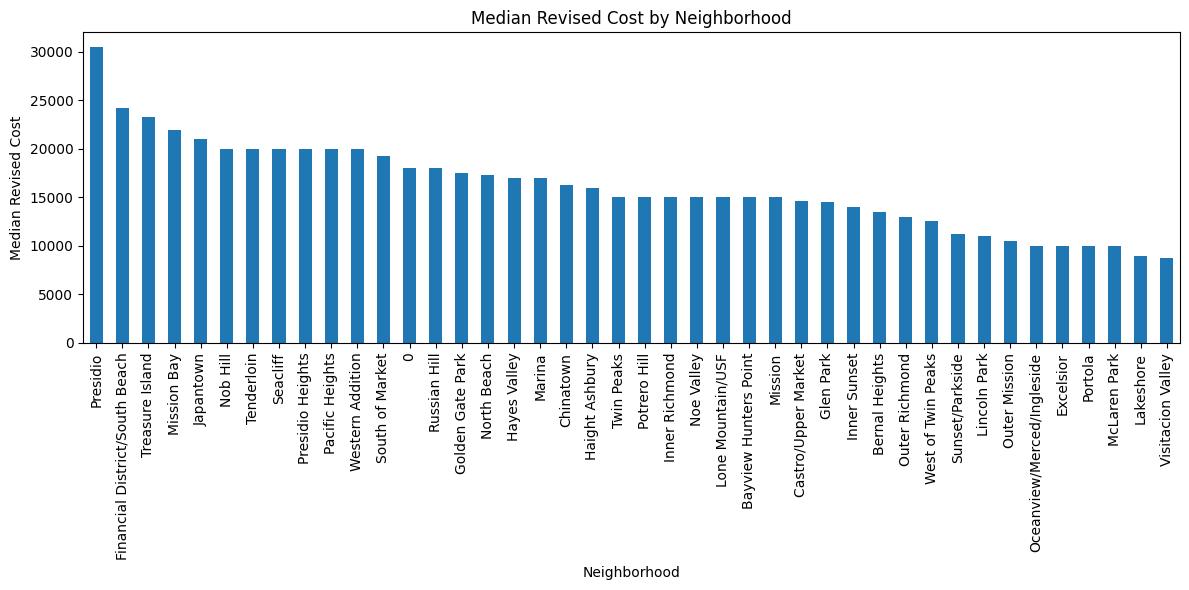

In [278]:
median_cost_by_neighborhood = df.groupby('Neighborhoods - Analysis Boundaries')['Revised Cost'].median().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
median_cost_by_neighborhood.plot(kind='bar')
plt.title('Median Revised Cost by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Median Revised Cost')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

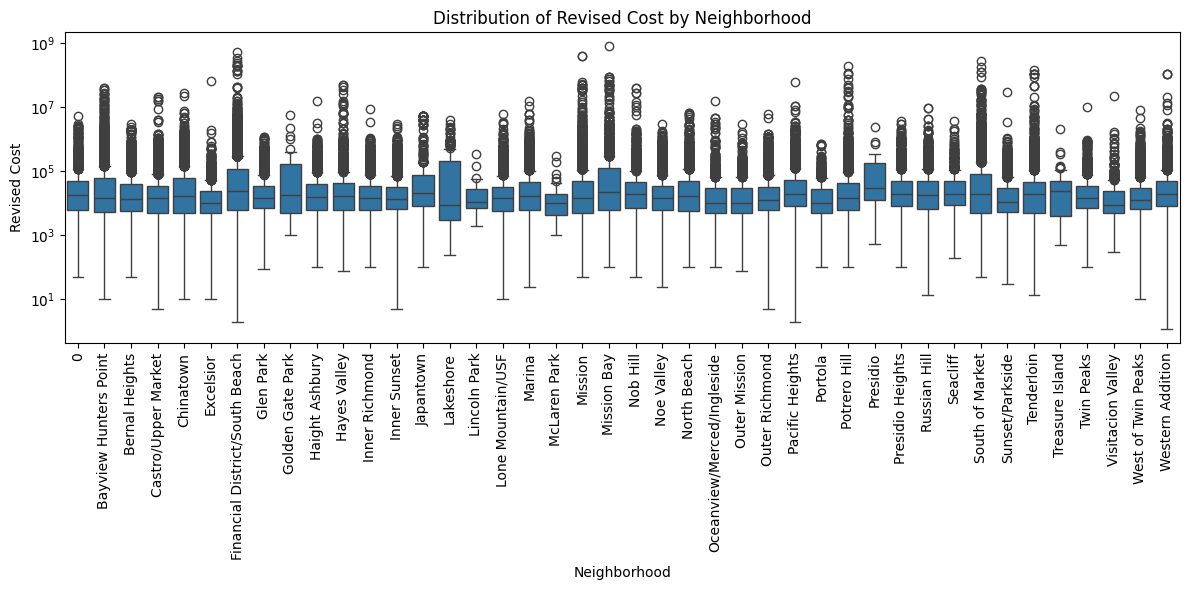

In [277]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhoods - Analysis Boundaries', y='Revised Cost', data=df)
plt.title('Distribution of Revised Cost by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Revised Cost')
plt.xticks(rotation=90)
plt.yscale('log')
plt.tight_layout()
plt.show()